# Simulate distribution of maneuver errors without multiple stars flag

This notebook attempts to estimate the distribution of maneuver errors that will occur if there is no OBC star processing filtering on the ACA multiple stars flag.

The process is as follows:

- Collect post-facto information for actual star catalogs since 2010:001.  This includes star AGASC ID, median Y, Z angle, magnitude, start time and obsid.
- For each star catalog, generate synthetic centroid errors using the star magnitude and a background based on the most recent dark calibration, adjusted to be at $T_{CCD}$.
  - $T_{CCD}$ is determined by sampling actual CCD temperature at a random time in the most recent 6 months and then adding a fixed offset.  The fixed offset would account for increasing the planning limit, but in this particular analysis the offset is 0.0.  This represents the case of patching the OBC without changing the planning limit.
  - For each star catalog, a total of 25 row, column offset pairs are applied to (roughly) simulate dithering.  
  - Row offset is [-2, -1, 0, 1, 2] pixels, and likewise for columns.
  - All "readout windows" are shifted accordingly and the corresponding dark current image pixels determine the image background for centroiding.
  - Centroiding is a first-moment centroid using the 6 x 6 mousebitten image.
  - The star "image" is actually just a delta-function at the center of the readout window.  FM-centroiding is linear so this simplification doesn't impact the results.
- The simulated centroid errors due to the non-uniform background generate an attitude error.
- This is assumed to correspond to the instantaneous error in fitting the constellation of true star positions to the perturbed positions.
- The fit is parametrized by a rotation and an offset ($d\theta_X$, $dY$, and $dZ$)
- These values are determined using a linear matrix first-order approximation (least-squares fit via matrix pseudo-inversion).
- The $d\theta_X$ values are collected and plotted as a histogram.
- In order to estimate the resultant manuever errors, for each $d\theta_X$ a maneuver angle is drawn randomly from actual maneuvers since 2010:001.
- The maneuver error is $d\theta_X * \sin(\phi)$ where $\phi$ is the maneuver angle.

<img src="man_err_hist_delta_0.0.png">

In [107]:
import os
from itertools import izip, product
import numpy as np
from scipy import linalg
from astropy.table import Table
from mica.archive.aca_dark import dark_cal
import chandra_aca
from kadi import events
from matplotlib import pyplot as plt
%matplotlib inline
from Chandra.Time import DateTime
from Ska.engarchive import fetch_sci
from __future__ import division

In [2]:
def rot(theta_arcsec):
    """
    Rotation matrix for ``theta_arcsec`` angle
    """
    theta = np.radians(theta_arcsec / 3600.)
    c = np.cos(theta)
    s = np.sin(theta)
    m = np.array([[c ,s],
                  [-s, c]])
    return m

In [3]:
def m_rot_off(y, z):
    """
    First order approximation to a rotation and linear offset dtheta, dY, dZ
    where::
    
      |dy|       | dtheta |
      |  | = M . | dY     |
      |dz|       | dZ     |
    """
    M = np.array([[ z, 1, 0],
                  [-y, 0, 1]], 
                dtype=np.float64)
    return M

In [4]:
def transform_matrix(yz):
    ms = []
    for y, z in yz:
        ms.append(m_rot_off(y, z))
    M = np.vstack(ms)
    return M

In [5]:
def write_guide_stats_to_npy():
    from Ska.DBI import DBI
    db = DBI(dbi='sybase', server='sybase', user='aca_read')
    dat = db.fetchall('select obsid, obi, id as agasc_id, type, kalman_tstart, aoacyan_median as yag,'
                      ' aoaczan_median as zag, aoacmag_median as mag, n_samples, mult_star_samples, slot'
                      ' from trak_stats_data'
                      ' WHERE kalman_datestart > "2010"'
                      ' AND aoacyan_median > -3000 AND aoaczan_median > -3000'
                      ' AND type != "FID"')
    np.save('guide_stats.npy', np.array(dat))
    db.conn.close()

In [6]:
def rotate_yag_zag(yag, zag, theta_arcsec):
    yzT = np.vstack([yag,
                     zag])
    yzrT = rot(theta_arcsec).dot(yzT)
    return yzrT[0, :], yzrT[1, :]    

In [7]:
def calc_Minv(yag, zag):
    yzT = np.vstack([yag, 
                     zag])
    yz = yzT.T
    M = transform_matrix(yz)
    Minv = linalg.inv(M.T.dot(M)).dot(M.T)
    return Minv


In [8]:
def solve_theta_dy_dz(yag, zag, dyag, dzag, Minv=None):
    if Minv is None:
        Minv = calc_Minv(yag, zag)
    dyzT = np.vstack([dyag, 
                      dzag])
    dyz_1d = dyzT.T.ravel()
    
    theta, dy, dz = Minv.dot(dyz_1d)
    return np.degrees(theta) * 3600, dy, dz

In [9]:
if not os.path.exists('guide_stats.npy'):
    write_guide_stats_to_npy()

guide_stats = Table(np.load('guide_stats.npy'))
g_guide_stats = guide_stats.group_by(['obsid', 'obi'])

In [10]:
g_guide_stats[:8]

obsid,obi,agasc_id,type,kalman_tstart,yag,zag,mag,n_samples,mult_star_samples,slot
int64,int64,int64,string24,float64,float64,float64,float64,int64,int64,int64
9930,0,241700520,BOT,380024188.192,1702.025,2066.9,8.625,14669,0,3
9930,0,312870352,BOT,380024188.192,-2262.7,-2011.9,8.8125,14669,6,4
9930,0,312872256,BOT,380024188.192,-1525.1,-1718.025,8.0,14669,4,5
9930,0,313012784,GUI,380024188.192,828.325,2289.05,8.25,14669,0,6
10070,0,820643128,BOT,382046800.294,2017.0,1328.8,7.4375,28929,0,3
10070,0,894967360,BOT,382046800.294,-2040.325,926.5,7.1875,28929,0,4
10070,0,896671000,BOT,382046800.294,-2169.5,-2288.5,8.625,28929,2,5
10070,0,896671704,BOT,382046800.294,-607.475,-777.05,7.875,28929,2,6


### Test for the first obsid in groups

In [11]:
g0 = g_guide_stats.groups[0]
g0

obsid,obi,agasc_id,type,kalman_tstart,yag,zag,mag,n_samples,mult_star_samples,slot
int64,int64,int64,string24,float64,float64,float64,float64,int64,int64,int64
9930,0,241700520,BOT,380024188.192,1702.025,2066.9,8.625,14669,0,3
9930,0,312870352,BOT,380024188.192,-2262.7,-2011.9,8.8125,14669,6,4
9930,0,312872256,BOT,380024188.192,-1525.1,-1718.025,8.0,14669,4,5
9930,0,313012784,GUI,380024188.192,828.325,2289.05,8.25,14669,0,6


In [12]:
yag, zag, mag = g0['yag'], g0['zag'], g0['mag']

#### Test with simple offset

In [13]:
dyag = np.array([1., 1, 1, 1])
dzag = np.array([2, 2, 2, 2])
solve_theta_dy_dz(yag, zag, dyag, dzag)

(-1.1181637552020176e-14, 1.0, 2.0000000000000004)

#### Test with pure rotation

In [14]:
yagr, zagr = rotate_yag_zag(yag, zag, 30.0)
dyag = yagr - yag
dzag = zagr - zag
solve_theta_dy_dz(yag, zag, dyag, dzag)

(29.999999894223954, 3.3250101298673085e-06, -1.6553655979648085e-06)

#### Test with rotation and offset

In [15]:
yagr, zagr = rotate_yag_zag(yag, zag, 30.0)
dyag = yagr - yag + np.array([1., 1, 1, 1])
dzag = zagr - zag + np.array([2, 2, 2, 2])
solve_theta_dy_dz(yag, zag, dyag, dzag)

(29.999999894223937, 1.0000033250101299, 1.9999983446344021)

In [16]:
def get_dark_image(date=None, ccd_temp=-14.0):
    dc = dark_cal.get_dark_cal_props(date=None, select='nearest', include_image=True)
    scale = dark_cal.dark_temp_scale(dc['ccd_temp'], ccd_temp)
    image = dc['image'] * scale
    return image

In [17]:
dark_image = get_dark_image(ccd_temp=-15.0)

In [18]:
row0, col0 = np.round(chandra_aca.yagzag_to_pixels(yag, zag))

In [19]:
import contextlib

@contextlib.contextmanager
def printoptions(*args, **kwargs):
    original = np.get_printoptions()
    np.set_printoptions(*args, **kwargs)
    yield 
    np.set_printoptions(**original)

In [20]:
irow, icol = np.mgrid[0:6, 0:6] - 2.5

def starcat_theta_dy_dz(stars, dark_image, d_rows=[0], d_cols=[0], star_row=0.0, star_col=0.0):
    theta_arcsecs = []
    dys = []
    dzs = []
    dyags_list = []
    dzags_list = []
    bkg_imgs_list = []
    
    yags, zags, mags = stars['yag'], stars['zag'], stars['mag']
    rows, cols = chandra_aca.yagzag_to_pixels(yags, zags)
    Minv = calc_Minv(yags, zags)
    
    # Iterate over integer row and column offsets, crudely emulating dither
    for d_row in d_rows:
        for d_col in d_cols:
            row_centroids = []
            col_centroids = []
            bkg_imgs = []
            
            # Iterate over stars
            for row, col, mag in izip(rows, cols, mags):
                row += d_row
                col += d_col
                if np.abs(row) > 508 or np.abs(col) > 508:
                    break
                row0 = int(row + 512 - 3)
                col0 = int(col + 512 - 3)
                
                # Extract the mouse-bitten background
                bkg = dark_image[row0:row0 + 6, col0:col0 + 6].copy()
                bkg[0, 0] = bkg[0, 5] = bkg[5, 0] = bkg[5, 5] = 0
                bkg_sum = np.sum(bkg)
                
                star_sum = chandra_aca.mag_to_count_rate(mag)
                row_centroid = (star_sum * star_row + np.sum(irow * bkg)) / (star_sum + bkg_sum)
                col_centroid = (star_sum * star_col + np.sum(icol * bkg)) / (star_sum + bkg_sum)
                
                row_centroids.append(row_centroid)
                col_centroids.append(col_centroid)
                bkg_imgs.append(bkg)
 
            else:  # Made it through loop with no break so all centroids were computed
                
                # Now compute the dyags and dzags for all the stars given the row and col centroid offsets
                yag_cs, zag_cs = chandra_aca.pixels_to_yagzag(row_centroids, col_centroids)
                yag_0s, zag_0s = chandra_aca.pixels_to_yagzag(np.zeros(len(stars)), np.zeros(len(stars)))
                dyags = yag_cs - yag_0s
                dzags = zag_cs - zag_0s

                # And finally compute the attitude error
                theta_arcsec, dy, dz = solve_theta_dy_dz(yags, zags, dyags, dzags, Minv=Minv)

                theta_arcsecs.append(theta_arcsec)
                dys.append(dy)
                dzs.append(dz)
                dyags_list.append(dyags)
                dzags_list.append(dzags)
                bkg_imgs_list.append(bkg_imgs)
                
    if d_rows == [0] and d_cols == [0]:
        return theta_arcsecs[0], dys[0], dzs[0], dyags_list[0], dzags_list[0], bkg_imgs_list[0]
    else:
        return theta_arcsecs, dys, dzs, dyags_list, dzags_list, bkg_imgs_list

In [21]:
def plot_solution(stars, dyags, dzags, theta_arcsec, dy, dz):
    scale = 1000
    plt.figure(figsize=(6, 6))
    yags, zags = stars['yag'] ,stars['zag']
    yzT = np.vstack([yags, 
                     zags]) 
    M = transform_matrix(yzT.T)
    dyz = M.dot([np.radians(theta_arcsec / 3600.), dy, dz]).reshape(-1, 2)
    fit_dyags, fit_dzags = dyz[:, 0], dyz[:, 1]
    plt.plot(yags, zags, 'or')
    plt.plot(yags + dyags * scale, zags + dzags * scale, '.b')
    for yag, zag, dyag, dzag in zip(yags, zags, dyags, dzags):
        plt.arrow(yag, zag, dyag * scale, dzag * scale, width=5)
    plt.plot(yags + fit_dyags * scale, zags + fit_dzags * scale, '.m')
    for yag, zag, dyag, dzag in zip(yags, zags, fit_dyags, fit_dzags):
        plt.arrow(yag, zag, dyag * scale, dzag * scale, width=5, color='m')
    plt.xlim(-2600, 2600)
    plt.ylim(-2600, 2600)
    plt.grid()
    print(np.mean(dyags - fit_dyags), np.mean(dzags - fit_dzags))
    

In [22]:
stars = g_guide_stats.groups[12]

theta_arcsec, dy, dz, dyags, dzags, bkg_imgs = starcat_theta_dy_dz(stars, get_dark_image(ccd_temp=-18.0))
print('T_ccd=-18C theta={:.3f} dy={:.3f} dz={:.3f} \ndyags={} \ndzags={}\n'.format(theta_arcsec, dy, dz, dyags, dzags))

theta_arcsec, dy, dz, dyags, dzags, bkg_imgs = starcat_theta_dy_dz(stars, get_dark_image(ccd_temp=-12.0))
print('T_ccd=-12C theta={:.3f} dy={:.3f} dz={:.3f} \ndyags={} \ndzags={}'.format(theta_arcsec, dy, dz, dyags, dzags))

T_ccd=-18C theta=28.350 dy=0.170 dz=0.069 
dyags=[ 0.04566733 -0.04486627 -0.33998201  0.54823757 -0.01739931] 
dzags=[ 0.04511688 -0.11074894  0.27713819 -0.13948695 -0.03242633]

T_ccd=-12C theta=43.873 dy=0.264 dz=0.106 
dyags=[ 0.07733236 -0.07088519 -0.52584355  0.85205268 -0.02959455] 
dzags=[ 0.07640024 -0.17497471  0.42864421 -0.21678601 -0.05515406]


(-9.7144514654701191e-18, 2.4980018054066023e-17)
(1.1102230246251566e-17, 2.2204460492503132e-17)
(0.0, -5.551115123125783e-18)


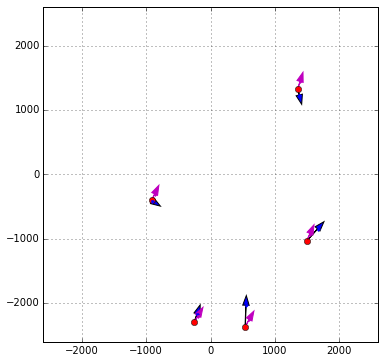

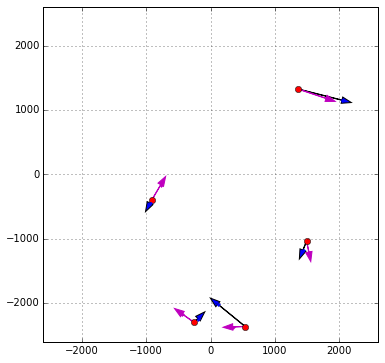

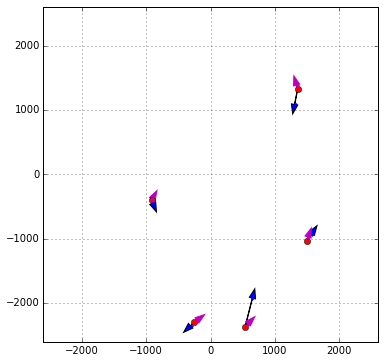

In [23]:
stars = g_guide_stats.groups[12]
theta_arcsecs, dys, dzs, dyags_list, dzags_list, bkg_imgs_list = starcat_theta_dy_dz(
    stars, dark_image, d_rows=[-2, 0, 2])
for theta_arcsec, dy, dz, dyags, dzags in izip(theta_arcsecs, dys, dzs, dyags_list, dzags_list):
    plot_solution(stars, dyags, dzags, theta_arcsec, dy, dz)

In [37]:
dark_image_cache = {}

def get_dark_image_from_cache(ccd_temp):
    ccd_temp = np.round(ccd_temp * 4) / 4.0  # round to nearest 0.25 degC
    if ccd_temp not in dark_image_cache:
        dark_image_cache[ccd_temp] = get_dark_image(ccd_temp=ccd_temp)
    return dark_image_cache[ccd_temp]

In [38]:
def calc_obsids_thetas(delta_ccd_temp=1.0, max_starcats=150, d_rows=[-2, -1, 0, 1, 2],
                         d_cols=[-2, -1, 0, 1, 2]):
    ccd_tlm = fetch_sci.Msid('aacccdpt', DateTime() - 180, stat='5min')
    obsids = []
    thetas = []
    for i, stars in enumerate(g_guide_stats.groups):
        ccd_temp = np.random.choice(ccd_tlm.vals) + delta_ccd_temp
        dark_image = get_dark_image_from_cache(ccd_temp)
        theta_arcsecs, dys, dzs, dyags_list, dzags_list, bkg_imgs_list = starcat_theta_dy_dz(
            stars, dark_image,                                         
            d_rows=d_rows,                                                                  
            d_cols=d_cols)
        thetas.append(np.abs(theta_arcsecs))
        obsids.append(stars['obsid'][0] * np.ones(len(theta_arcsecs), dtype=int))
        if max_starcats and i > max_starcats:
            break
        if i % 500 == 0:
            print(i)
            
    return Table([np.concatenate(obsids), np.concatenate(thetas)], names=['obsid', 'theta'])

In [53]:
obsids_thetas = calc_obsids_thetas(max_starcats=None, delta_ccd_temp=0.0)

0
500
1000
1500
2000
2500
3000
3500
4000
4500
5000
5500
6000
6500
7000
7500
8000
8500


In [54]:
obsids_thetas = obsids_thetas.group_by('obsid')
theta_maxes = obsids_thetas.groups.aggregate(np.max)
theta_maxes.sort('theta')

In [86]:
theta_maxes[-10:]

obsid,theta
int64,float64
12241,98.9010483897
55470,100.675644899
55084,104.161803394
15251,111.286440375
16544,112.418027172
12880,129.326173983
13190,130.248948451
13392,133.637068476
16500,774.52558614


In [56]:
obsids = np.unique(guide_stats['obsid'])
science_obsids = obsids[obsids < 50000]
tstart = guide_stats['kalman_tstart']
years = (np.max(tstart) - np.min(tstart)) / (365.25 * 86400)
print('Science obsids / year = {:.0f}'.format(len(science_obsids) / years))

Science obsids / year = 868


In [88]:
# Remove Venus observations
ok = (obsids_thetas['obsid'] != 16500) & (obsids_thetas['obsid'] != 16501)
obsids_thetas = obsids_thetas[ok]

In [89]:
manvrs = events.manvrs.filter('2010:001').table
manvr_angles = np.random.choice(manvrs['angle'], size=len(obsids_thetas))
obsids_thetas['angle'] = manvr_angles

In [90]:
obsids_thetas['manerr'] = obsids_thetas['theta'] * np.sin(np.radians(manvr_angles))

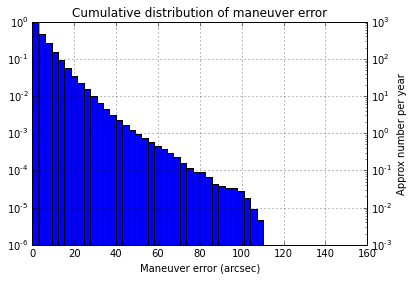

In [91]:
ax = plt.subplot(1, 1, 1)
plt.hist(obsids_thetas['manerr'], bins=np.linspace(0, 150, 50), normed=True, cumulative=-1, log=True)
plt.grid();
plt.title('Cumulative distribution of maneuver error')
plt.xlabel('Maneuver error (arcsec)')
ax2 = ax.twinx()
ax2.set_ylim(0.001, 1000)
ax2.set_yscale('log')
ax2.set_ylabel('Approx number per year')
plt.savefig('man_err_hist_delta_0.0.png')

In [95]:
# Get manvrs since IRU calibration update on 2014:240, after which scale factor error has been small and stable
manvrs = events.manvrs.filter('2014:241').table
ok = manvrs['one_shot'] > 0
manvrs = manvrs[ok]
# i_manvrs = np.random.random_integers(len(manvrs), size=len(obsids_thetas)) - 1
# obsid_manvrs = manvrs[i_manvrs]
manvrs.sort('angle')

In [101]:
angles = np.random.uniform(0, 2 * np.pi, size=len(obsids_thetas))
i = np.searchsorted(manvrs['angle'], obsids_thetas['angle'])
i = np.clip(i, 0, len(manvrs) - 1)
# x = manvrs['one_shot'][i] + np.cos(angles) * obsids_thetas['manerr'] * 1
# y = np.sin(angles) * obsids_thetas['manerr'] * 1
x = obsids_thetas['manerr'] + np.cos(angles) * manvrs['one_shot'][i]
y = np.sin(angles) * manvrs['one_shot'][i]
obsids_thetas['full_manerr'] = np.sqrt(x ** 2 + y ** 2)

In [102]:
np.max(obsids_thetas['theta'])

133.63706847599011

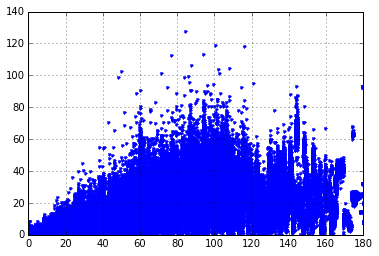

In [103]:
plt.plot(obsids_thetas['angle'], obsids_thetas['full_manerr'], '.')
plt.grid();

In [80]:
len(obsids_thetas)

214359

In [109]:
bad = (np.abs(x) > 90) | (np.abs(y) > 90)
np.count_nonzero(bad) / len(obsids_thetas) * 868

0.10528574760905061

In [34]:
def outlier_info(obsid, ccd_temp=-14.0):
    i_obsid = np.where(g_guide_stats.groups.keys['obsid'] == obsid)
    stars = g_guide_stats.groups[i_obsid]
    print(stars)
    d_rows=[-2, -1, 0, 1, 2]
    d_cols=[-2, -1, 0, 1, 2]
    dark_image = get_dark_image(ccd_temp)
    theta_arcsecs, dys, dzs, dyags_list, dzags_list, bkg_imgs_list = starcat_theta_dy_dz(
        stars, dark_image, d_rows=d_rows, d_cols=d_cols)
    row_cols = list(product(d_rows, d_cols))
    for i, theta_arcsec in enumerate(theta_arcsecs):
        if abs(theta_arcsec) < 100:
            continue
        print('theta={}\ndyags={}\ndzags={}\nrow_cols={}'
              .format(theta_arcsec, dyags_list[i], dzags_list[i], row_cols[i]))
        for bkg_imgs in bkg_imgs_list[i]:
            with printoptions(formatter={'float_kind': lambda x: '{:10.1f}'.format(x)}):
                for bkg_img in bkg_imgs:
                    print(bkg_img)
                print
